# Classification

## Task Overview
The task is to create, train, and evaluate a classification model based on a convolutional neural network (CNN) to predict the type of scene shown in outdoor photographs.
The dataset contains approximately 17,000 RGB images with a resolution of 126×126 pixels.
It is split into training and test sets across six categories: buildings, forest, glacier, mountain, sea, and street.

In [7]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, accuracy_score

## Task 1. Loading, preprocessing, and visualizing the data

Shapes:
X_train: (14034, 126, 126, 3)
y_train: (14034,)
X_test: (3000, 126, 126, 3)
y_test: (3000,)

Dtypes:
X_train: float32 range: (np.float32(0.0), np.float32(1.0))
X_test: float32 range: (np.float32(0.0), np.float32(1.0))


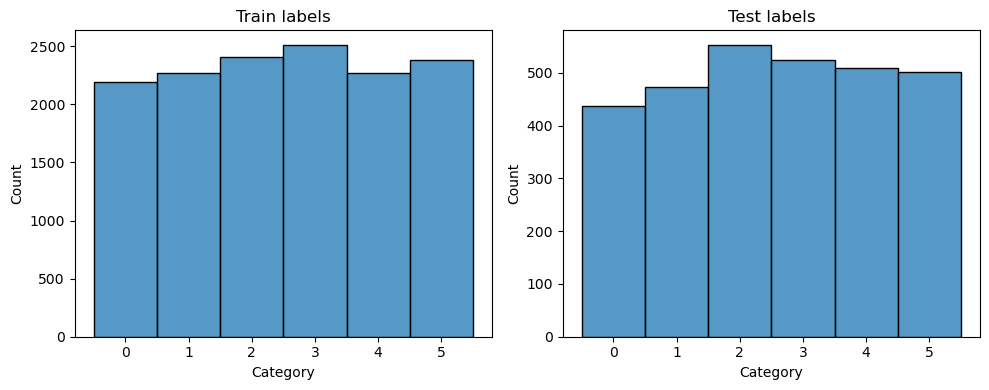

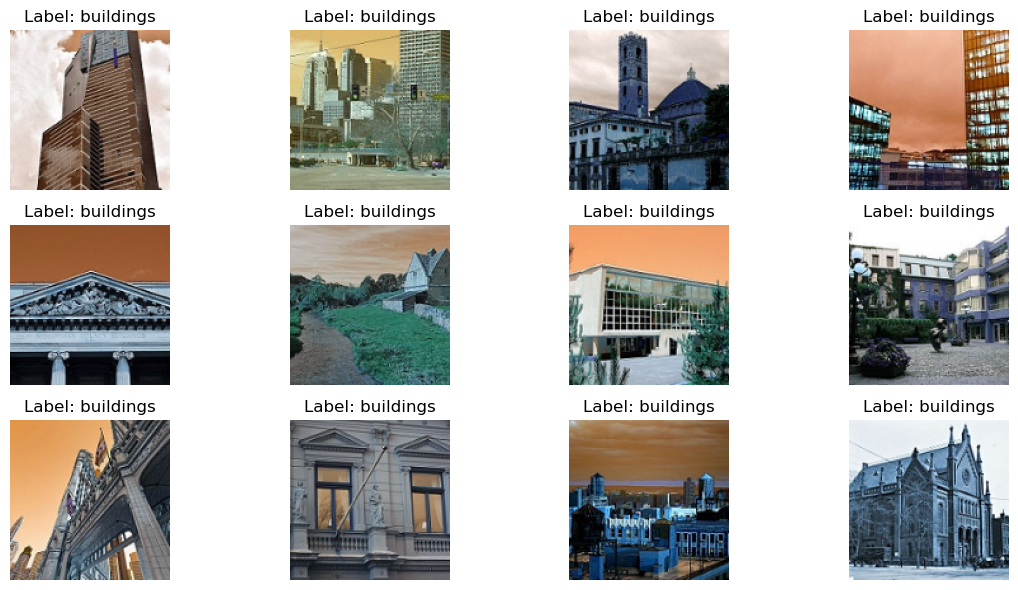

In [4]:
# 1. Loading the data
data = np.load("Intel_Image.npz", allow_pickle=True)

# 2. Data information
X_train = data["train_img"]
y_train = data["train_lab"]
X_test = data["test_img"]
y_test = data["test_lab"]

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

print("\nDtypes:")
print("X_train:", X_train.dtype, "range:", (X_train.min(), X_train.max()))
print("X_test:", X_test.dtype, "range:", (X_test.min(), X_test.max()))

# 3. Data normalization check
if X_train.max() > 1:
    X_train = X_train / 255.0
    X_test = X_test / 255.0

# 4. Class distribution histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=np.arange(7)-0.5, discrete=True)
plt.title("Train labels")
plt.xlabel("Category")
plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=np.arange(7)-0.5, discrete=True)
plt.title("Test labels")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

# 5. Sample test images
labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    label_idx = int(y_test[i])
    plt.title(f"Label: {labels[label_idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Task 2: Building, training, and evaluating the neural network model

In [ ]:
# 1. Model construction
model = keras.models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(126, 126, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(6, activation="softmax")  # 6 classes
])

# 2. Model visualization
model.summary()
plot_model(model, show_shapes=True)

# 3. Compilation
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Callbacks and training
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
 
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# 5. Learning curves plot
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True)
plt.gca().set_ylim(0, 1)
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.show()


/home/luki/miniconda3/envs/overview-of-data-science-tools/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-13 13:49:03.841217: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,715,430 (14.17 MB)

 Trainable params: 3,715,430 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/20


2025-05-13 13:49:04.226534: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2673645408 exceeds 10% of free system memory.


439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 158ms/step - accuracy: 0.5677 - loss: 1.0997 - val_accuracy: 0.6963 - val_loss: 0.8362
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.7661 - loss: 0.6374 - val_accuracy: 0.7723 - val_loss: 0.6436
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.8382 - loss: 0.4473 - val_accuracy: 0.7077 - val_loss: 0.8894
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.9075 - loss: 0.2740 - val_accuracy: 0.7617 - val_loss: 0.7672
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 71s 161ms/step - accuracy: 0.9418 - loss: 0.1778 - val_accuracy: 0.7670 - val_loss: 0.9127
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.9734 - loss: 0.0855 - val_accuracy: 0.7227 - val_loss: 1.2978
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 73s 165ms/step - accuracy: 0.9784 - loss: 0.0716 - val_accuracy: 0.7703 - val_loss: 1.1299


### Evaluation of Progress

Model Summary
- The architecture fully meets the task requirements.  
- **3.7 million parameters** — quite a lot, but justified due to the large dense layers.

Training Results
- **Accuracy** increases up to nearly **98%**
- **Validation accuracy** plateaus around **77–78%**  
  → A clear sign of **overfitting** starting from around **epoch 5**.

Learning Curves
- **Validation loss** starts to rise while **training loss** continues to drop → A classic case of **overfitting**.
- The model learns the training data very well but doesn't generalize perfectly.
- **EarlyStopping** worked well (stopped after 7 epochs)



  4/439 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step

2025-05-13 19:44:45.369757: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2673645408 exceeds 10% of free system memory.


439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


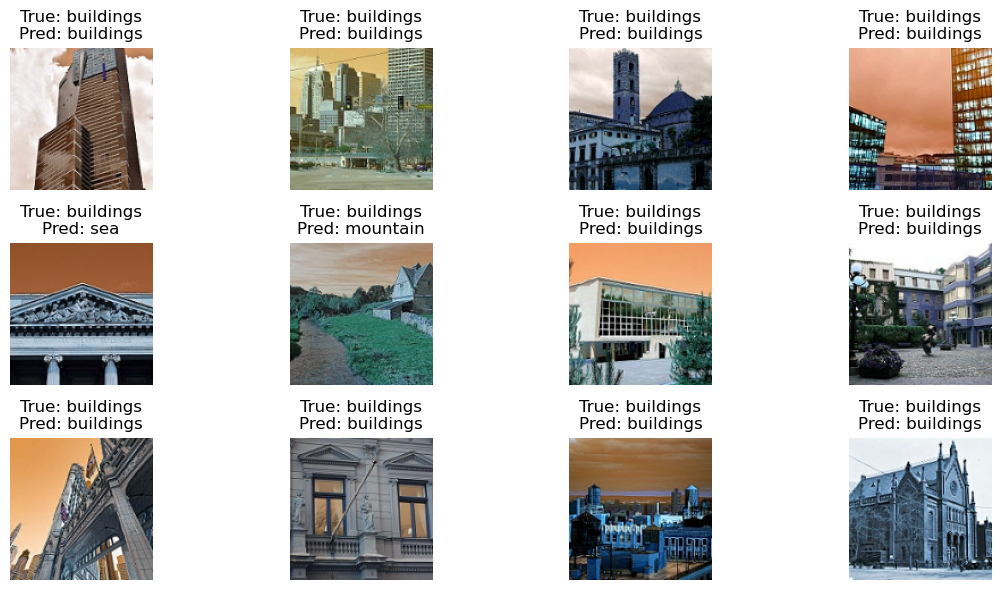

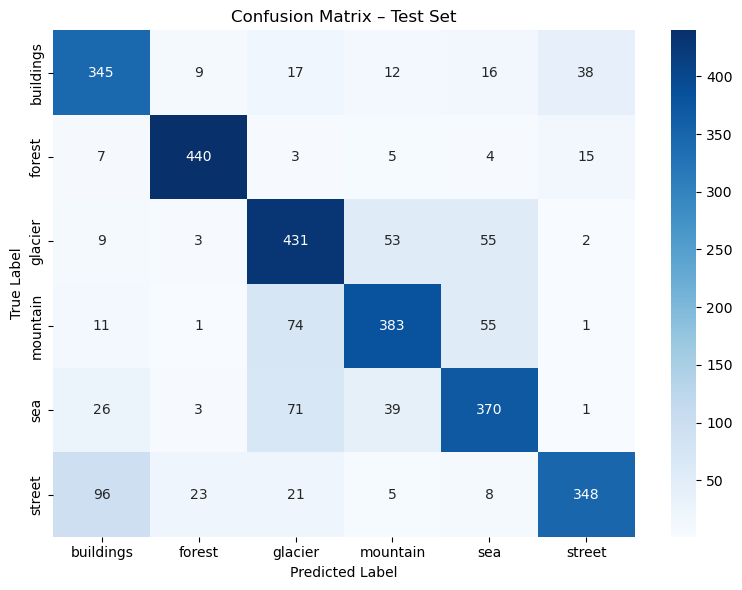

Train Accuracy: 0.8492
Test Accuracy:  0.7723


In [8]:
# 6. Predictions (for train and test sets)
y_pred_train = model.predict(X_train).argmax(axis=1)
y_pred_test = model.predict(X_test).argmax(axis=1)

# 7. Displaying a few examples with true and predicted labels
plt.figure(figsize=(12, 6))
labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    true_label = labels[int(y_test[i])]
    pred_label = labels[int(y_pred_test[i])]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 8. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 9. Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")


### Metric Results

- **Training accuracy:** 83.19%  
- **Test accuracy:** 76.13%  
- The gap indicates moderate overfitting, which could still be optimized.

---

### Observations Based on the Confusion Matrix

- The **"forest"** and **"street"** classes are recognized very well – few errors.
- The model struggles the most with **"sea"**, **"glacier"**, and **"mountain"** classes.
- The model tends to **overpredict the "buildings" class**, which is also evident in the image predictions.

---

### Conclusions

- The model captures general class features well, but some natural scenes (e.g., **"glacier" vs "mountain"** or **"sea"**) share similar visual patterns, making classification harder.
- Adding **normalization**, **dropout layers**, or **extending the convolutional architecture** (more `Conv2D`, fewer `Dense` layers) could improve generalization.
- Consider also applying **data augmentation** (rotation, shifting, scaling) to increase training diversity and reduce overfitting.
